In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
import seaborn as sns
import plotly.express as px
import sqlite3

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor

# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


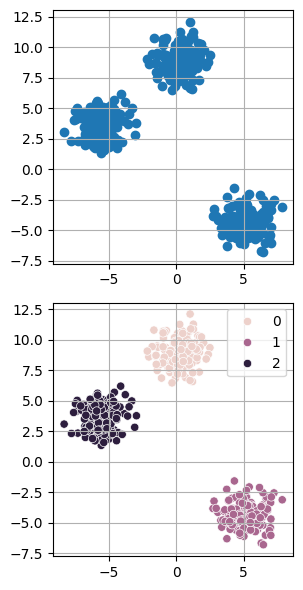

In [2]:
X,y = make_blobs(n_samples = 500,n_features = 2,centers = 3,random_state = 23)
fig, (axis, ax) = plt.subplots(2, gridspec_kw={'height_ratios':[1,1]}, figsize=[3,6])
axis.grid(True)
axis.scatter(X[:,0], X[:,1])
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=ax)
ax.grid(True)
fig.tight_layout()
plt.show()

In [3]:
DB = sqlite3.connect('aruodas3.db')
C = DB.cursor()
sql="""SELECT * FROM aruododuomenys;"""
df = pd.read_sql_query(sql, con=DB)

In [4]:
df.head()

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas
0,"34,93 m²",2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės
1,"66,64 m²",2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai
2,"66,89 m²",3,2,9,1980,Blokinis,Centrinis,Įrengtas,None,54.717923,25.238122,Vilnius,172000,Šeškinė
3,98 m²,3,2,5,2008,Mūrinis,Centrinis,Įrengtas,A+,54.691637,25.284638,Vilnius,615000,Šnipiškės
4,"46,23 m²",3,3,5,1969,Blokinis,Centrinis,Įrengtas,D,54.707286,25.286241,Vilnius,147500,Šnipiškės


In [5]:
df=df[df['miestas'] == 'Vilnius']
df=df.drop(columns='energetineklase')
df=df.dropna()

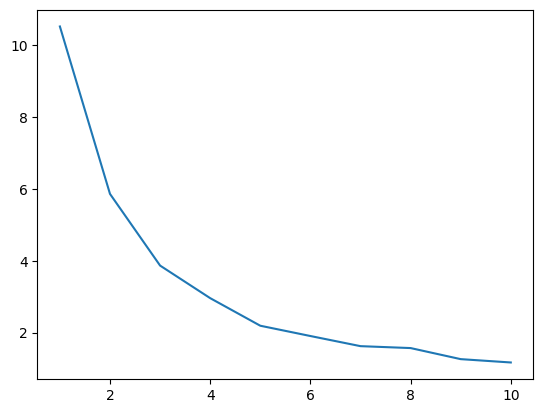

In [6]:
sse = []
for k in range(1,11):
    km = KMeans(n_clusters=k)
    km.fit(df[['ilguma', 'platuma']])
    sse.append(km.inertia_)

ax = sns.lineplot(x=[*range(1,11)], y=sse)
# ax.loglog()
plt.show()

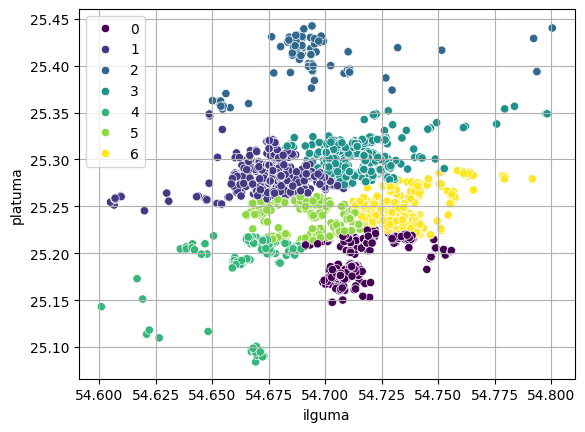

In [7]:
kmeans = KMeans(n_clusters=7)

predicted_labels = kmeans.fit_predict(df[['ilguma', 'platuma']])

ax = sns.scatterplot(x=df['ilguma'], y=df['platuma'], hue=predicted_labels, palette='viridis')

ax.grid(True)

plt.show()

In [8]:
df['cluster'] = predicted_labels

In [9]:
df_vid_kainos = df.groupby('cluster')['kaina'].mean().reset_index()
df_vid_kainos['kaina'] = df_vid_kainos['kaina'].apply(lambda x: round(x, 0))

In [10]:
df['vid_kaina'] = df['cluster'].map(df_vid_kainos.set_index('cluster')['kaina'])

In [11]:
df_vid_kainos.head(10)

,cluster,kaina
0,0,155208.0
1,1,295185.0
2,2,106763.0
3,3,193707.0
4,4,131076.0
5,5,224259.0
6,6,150498.0


In [12]:
fig = px.scatter_mapbox(
    df,
    lat="ilguma",
    lon="platuma", color="cluster",
    zoom=6,
    size_max=50, 
    title="Būsto kainos Vilniuje",
)

fig.update_layout(
    mapbox_style="open-street-map",  
    height=600
)

fig.show()

In [13]:
df_map= df.groupby('cluster').agg({'ilguma': 'mean', 'platuma': 'mean', 'vid_kaina': 'mean'}).reset_index()

In [14]:
df_map['vid_kaina_txt']=df_map['vid_kaina'].apply(lambda x: f'{x:.0f} €')

In [15]:
df_map

,cluster,ilguma,platuma,vid_kaina,vid_kaina_txt
0,0,54.718559,25.197539,155208.0,155208 €
1,1,54.677017,25.281086,295185.0,295185 €
2,2,54.695830,25.407700,106763.0,106763 €
3,3,54.713719,25.302423,193707.0,193707 €
4,4,54.666086,25.188178,131076.0,131076 €
5,5,54.691109,25.239270,224259.0,224259 €
6,6,54.735630,25.249889,150498.0,150498 €


In [16]:
fig = px.scatter_mapbox(
    df_map,
    lat="ilguma",
    lon="platuma",
    size='vid_kaina', 
    zoom=6, 
    size_max=60, 
    title="Kainų vidurkiai Vilniuje",
    text='vid_kaina_txt'
    
)

fig.update_layout(
    mapbox_style="open-street-map",  
    height=600
)

fig.show()

In [17]:
df['plotas']=df['plotas'].apply(lambda x: float(x.replace(' m²', '').replace(',', '.')))
df['kvm_kaina'] = df['kaina'] / df['plotas']

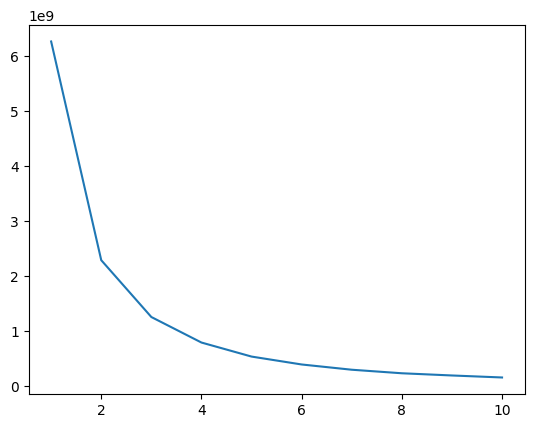

In [18]:
sse = []
for k in range(1,11):
    km = KMeans(n_clusters=k)
    km.fit(df[['kvm_kaina']])
    sse.append(km.inertia_)

ax = sns.lineplot(x=[*range(1,11)], y=sse)
# ax.loglog()
plt.show()

In [19]:
kmeans = KMeans(n_clusters=7)

predicted_labels = kmeans.fit_predict(df[['kvm_kaina']])


In [20]:
df['cluster_kaina'] = predicted_labels

In [21]:
fig = px.scatter_mapbox(
    df,
    lat="ilguma",
    lon="platuma", color='cluster_kaina',
    zoom=6,
    size_max=50, 
    title="Būsto kainos Vilniuje",
)

fig.update_layout(
    mapbox_style="open-street-map",  
    height=600
)

fig.show()

In [22]:
from sklearn.model_selection import GridSearchCV # su gridsearchcv tuninsime parametrus
# Define the parameter grid
param_grid = {
'n_clusters': range(2, 9 + 1),
'init': ['k-means++', 'random'],
'n_init': [5, 10, 15],
'max_iter': [100, 200, 300, 400, 500],
'tol': [0.0001, 0.001, 0.01],
'algorithm': ['lloyd', 'full', 'elkan'],
'random_state': [0, 42, 100]
}

# Create the KMeans object
kmeans = KMeans(random_state=42)

# Perform grid search
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(df[['kvm_kaina']].values) # fitinam X, kurį susigeneravom darbo pradžioje

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print('Optimal number of clusters based on parameter grid: ' + str(grid_search.best_params_['n_clusters']))

Best hyperparameters:  {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 9, 'n_init': 5, 'random_state': 0, 'tol': 0.001}
Optimal number of clusters based on parameter grid: 9


C:\Users\pauli\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


10800 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pauli\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\pauli\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\pauli\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    validat